# Importing Packages


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    RocCurveDisplay
)

# Loading Data
### Load main dataset

In [17]:
df = pd.read_csv('C:/Users/richard.shirandula/Downloads/clean_data_after_eda.csv')

#### Convert date columns to datetime

In [18]:
date_cols = ["date_activ", "date_end", "date_modif_prod", "date_renewal"]
for col in date_cols:
    df[col] = pd.to_datetime(df[col], format='%Y-%m-%d')

#### Load price data

In [19]:
price_df = pd.read_csv('C:/Users/richard.shirandula/Downloads/price_data (1).csv')
price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')


# Feature Engineering
### a. Price Difference Features
#### Group off-peak prices by companies and month

In [20]:
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg(
    {'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}
).reset_index()

#### Get January and December prices

In [21]:
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
diff = pd.merge(
    dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}),
    jan_prices.drop(columns='price_date'),
    on='id'
)
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] - diff['price_off_peak_fix']
diff = diff[['id', 'offpeak_diff_dec_january_energy', 'offpeak_diff_dec_january_power']]

# Merge with main dataset
df = pd.merge(df, diff, on='id', how='left')

### b. Duration Features

In [22]:
# Account a# Account age in days
df['account_age_days'] = (df['date_end'] - df['date_activ']).dt.days

# Days since last modification
df['days_since_modif_prod'] = (df['date_end'] - df['date_modif_prod']).dt.days

# Days until renewal
df['days_until_renewal'] = (df['date_renewal'] - df['date_end']).dt.days

# Model Preparation
### Define features and target

In [23]:
X = df.drop(columns=['id', 'churn', 'date_activ', 'date_end', 'date_modif_prod', 'date_renewal'])
y = df['churn']

# Convert categorical variables to dummy variables
X = pd.get_dummies(X, drop_first=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter Tuning with GridSearchCV
### Define the parameter grid

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='roc_auc')

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

# Train the final model with the best parameters
final_model = RandomForestClassifier(**best_params, random_state=42)
final_model.fit(X_train, y_train)

# Make predictions
y_pred = final_model.predict(X_test)
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

Fitting 3 folds for each of 108 candidates, totalling 324 fits


In [13]:
# Evaluate the final model
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC Score: ", roc_auc_score(y_test, y_pred_proba))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95      2617
           1       1.00      0.03      0.05       305

    accuracy                           0.90      2922
   macro avg       0.95      0.51      0.50      2922
weighted avg       0.91      0.90      0.85      2922

Confusion Matrix:
 [[2617    0]
 [ 297    8]]
ROC AUC Score:  0.6693034822754124


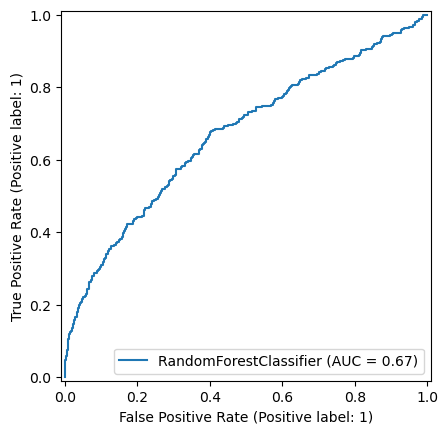

In [14]:
# Plot ROC Curve
RocCurveDisplay.from_estimator(final_model, X_test, y_test)
plt.show()